## Problem Statement : Development of an NLP Model for Text Analytics and Classification

### The Objective of the Project is to develop an NLP model that categorizes complaint based on victim, type of fraud and other relevant parameters used for text classification and preparing the final model.

## Lets First Understand the Dataset : 

Datasets contain the following columns:

category: The main type of crime (e.g. Financial Fraud, Cyber Attack)

sub_category: Sub-type of the crime (e.g. Fraud Call, SQL Injection)

crimeaditionalinfo: Textual description of the crime, which will serve as input for the NLP model

After understanding of the goal we can build our model that can use the textual description (crimeaditionalinfo) to predict the category and sub_category of our dataset.

## Lets do the Data Preprocessing for prepairing the cleaned data for Model as input: 
Handle Missing Values:
-- First we will check the missing values in crimeaditionalinfo, category, and sub_category of all recpective cloumn in the dataset.
-- Fter finding the Missing value we will Impute or remove the same rows with missing critical information.

#  Importt Libraries 

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load and Preprocess Data

In [40]:
# Load datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Display dataset shapes
print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (93686, 3)
Test dataset shape: (31229, 3)


In [41]:
# Check missing values in critical columns for the train dataset
train_missing_values = train_data[['crimeaditionalinfo', 'category', 'sub_category']].isnull().sum()
print("Missing values in the train dataset:")
print(train_missing_values)

# Check missing values in critical columns for the test dataset
test_missing_values = test_data[['crimeaditionalinfo', 'category', 'sub_category']].isnull().sum()
print("\nMissing values in the test dataset:")
print(test_missing_values)

Missing values in the train dataset:
crimeaditionalinfo      21
category                 0
sub_category          6591
dtype: int64

Missing values in the test dataset:
crimeaditionalinfo       7
category                 0
sub_category          2236
dtype: int64


Visualizing missing data in the train dataset...


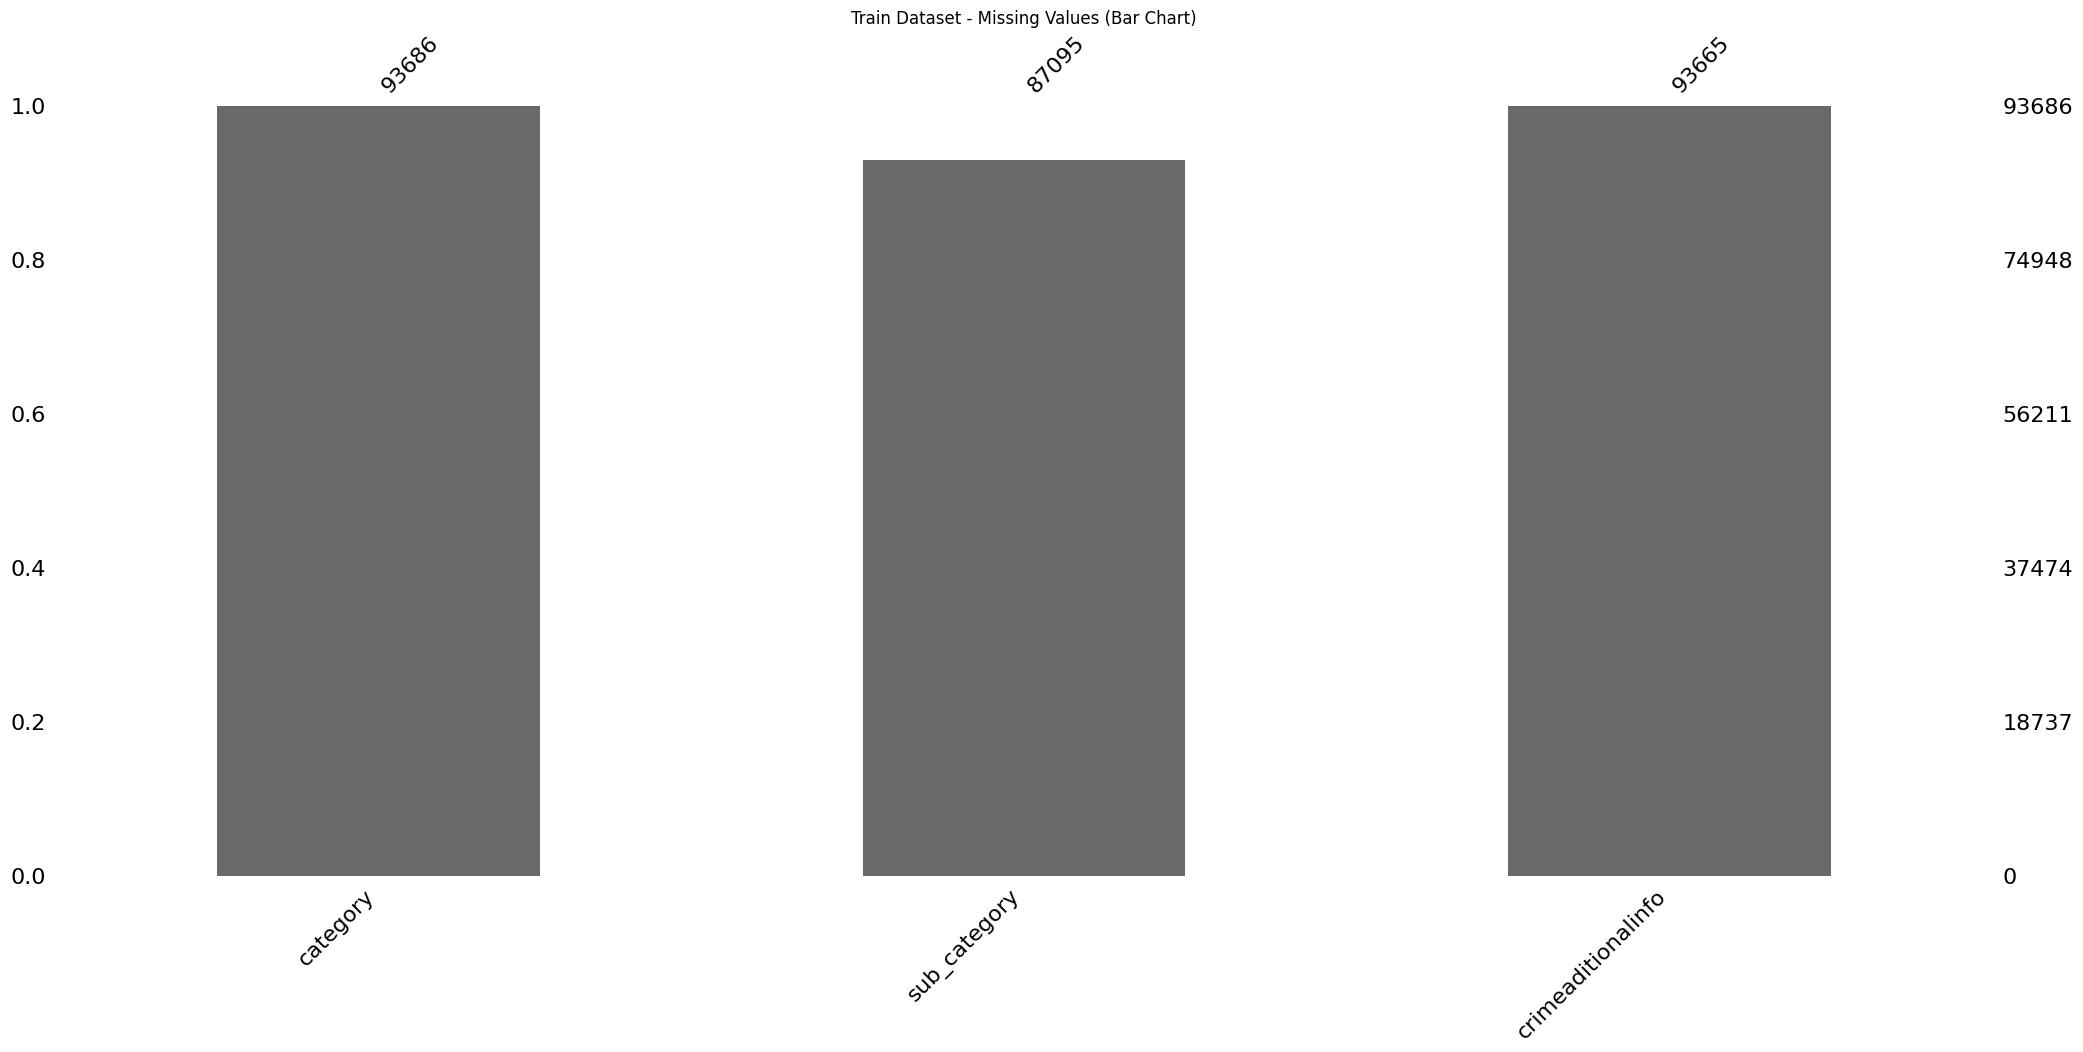

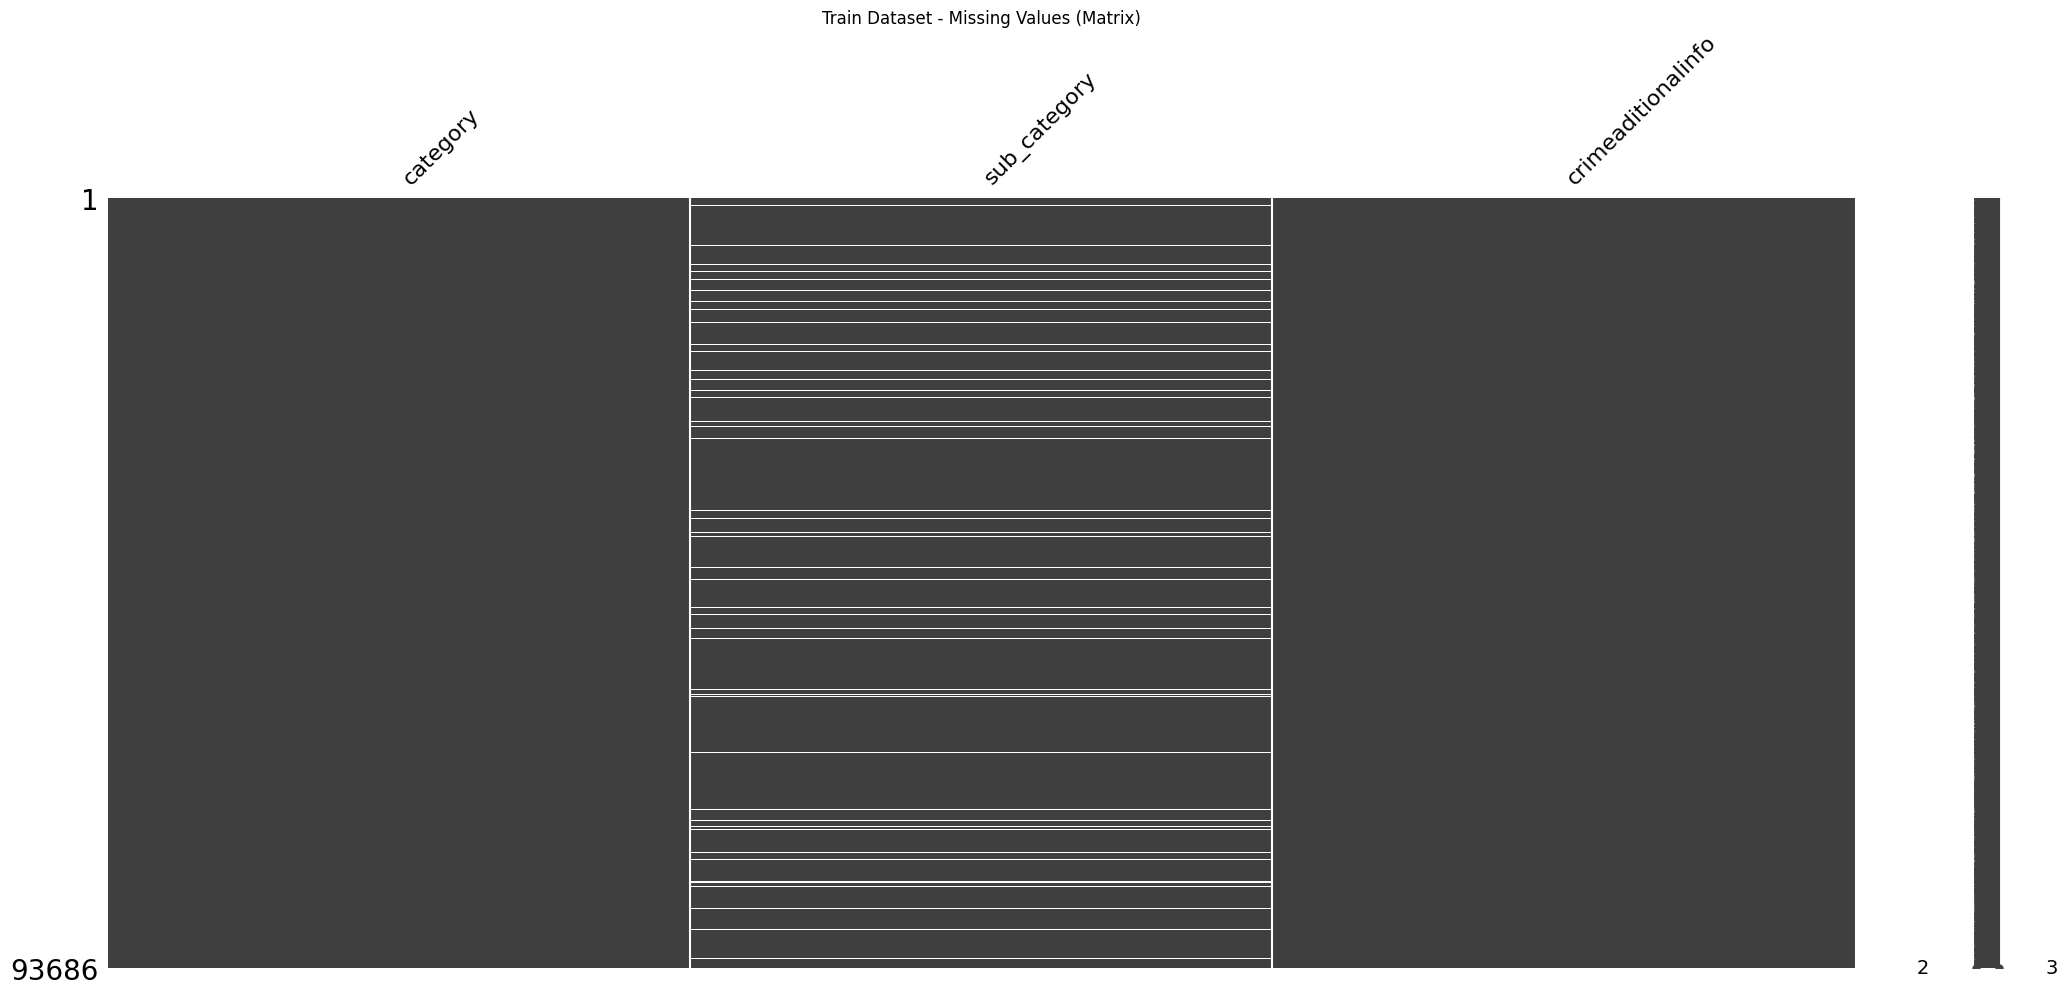

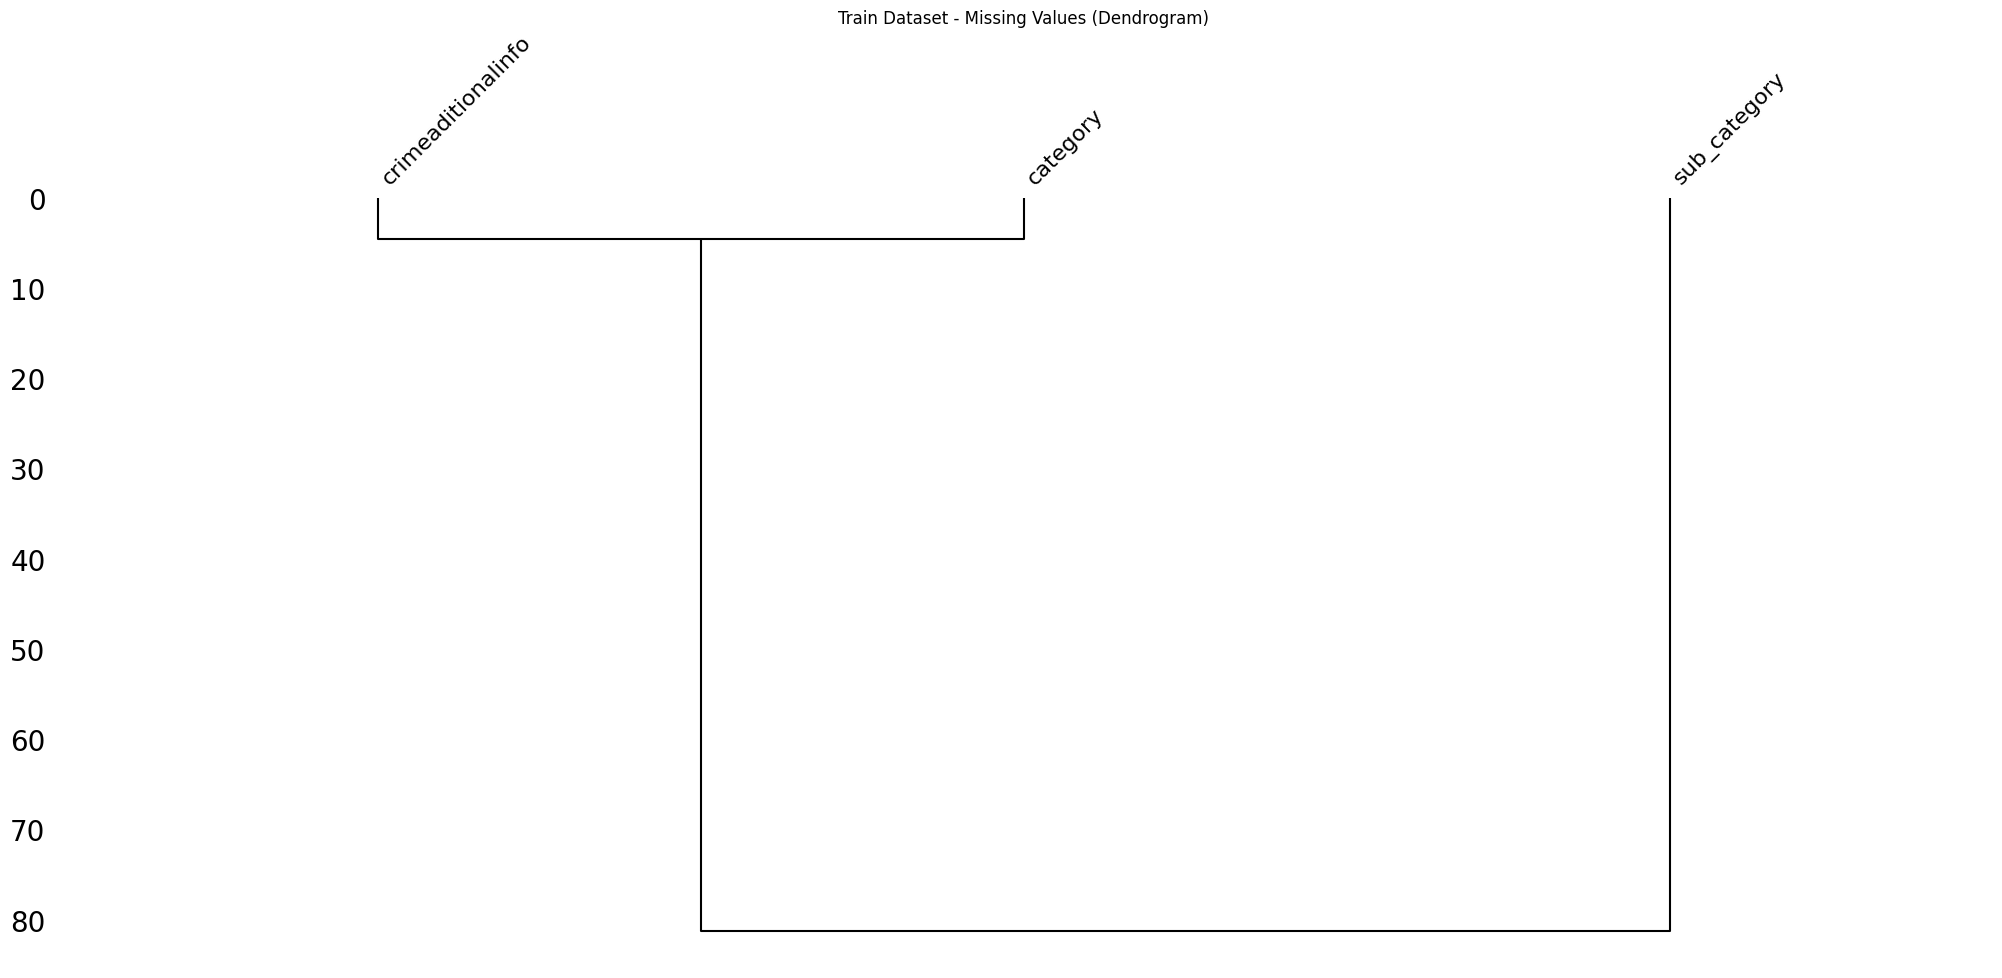

Visualizing missing data in the test dataset...


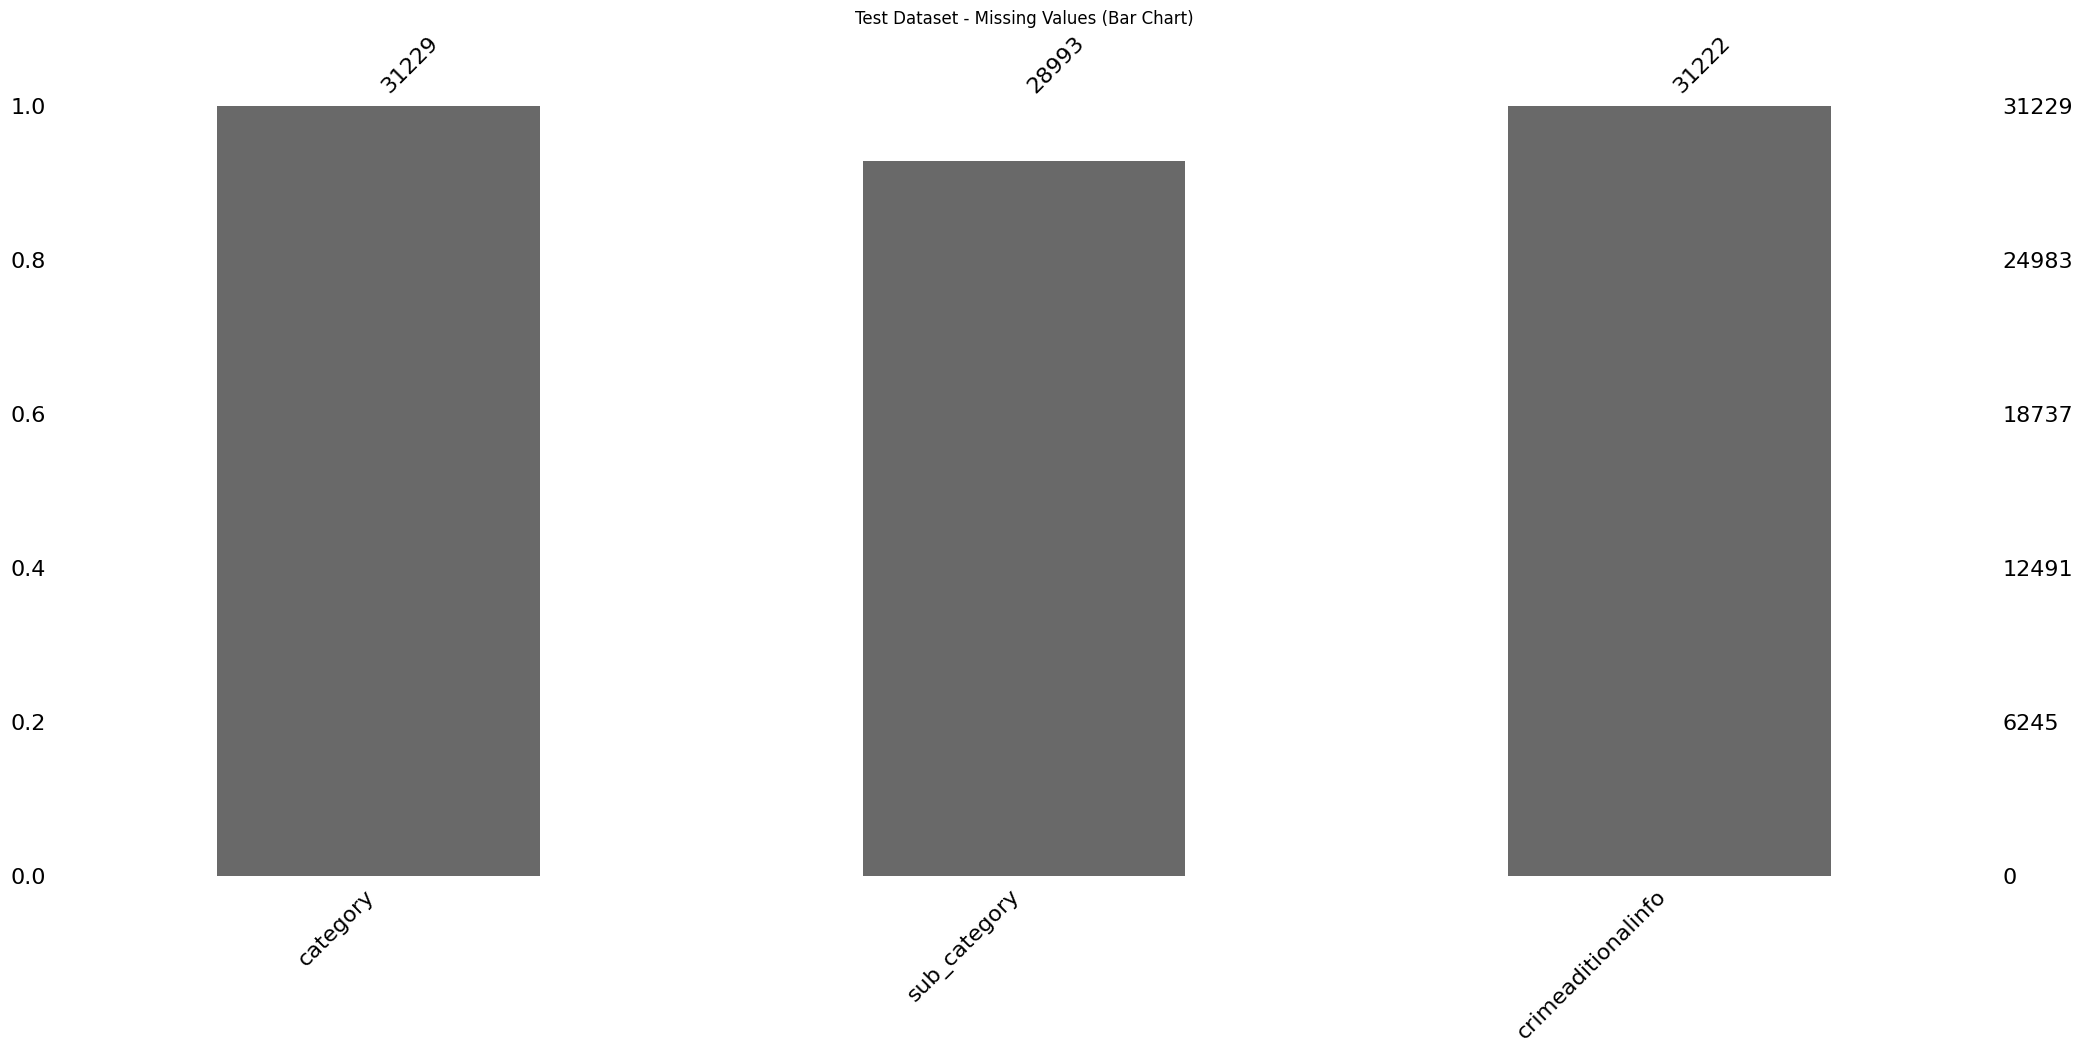

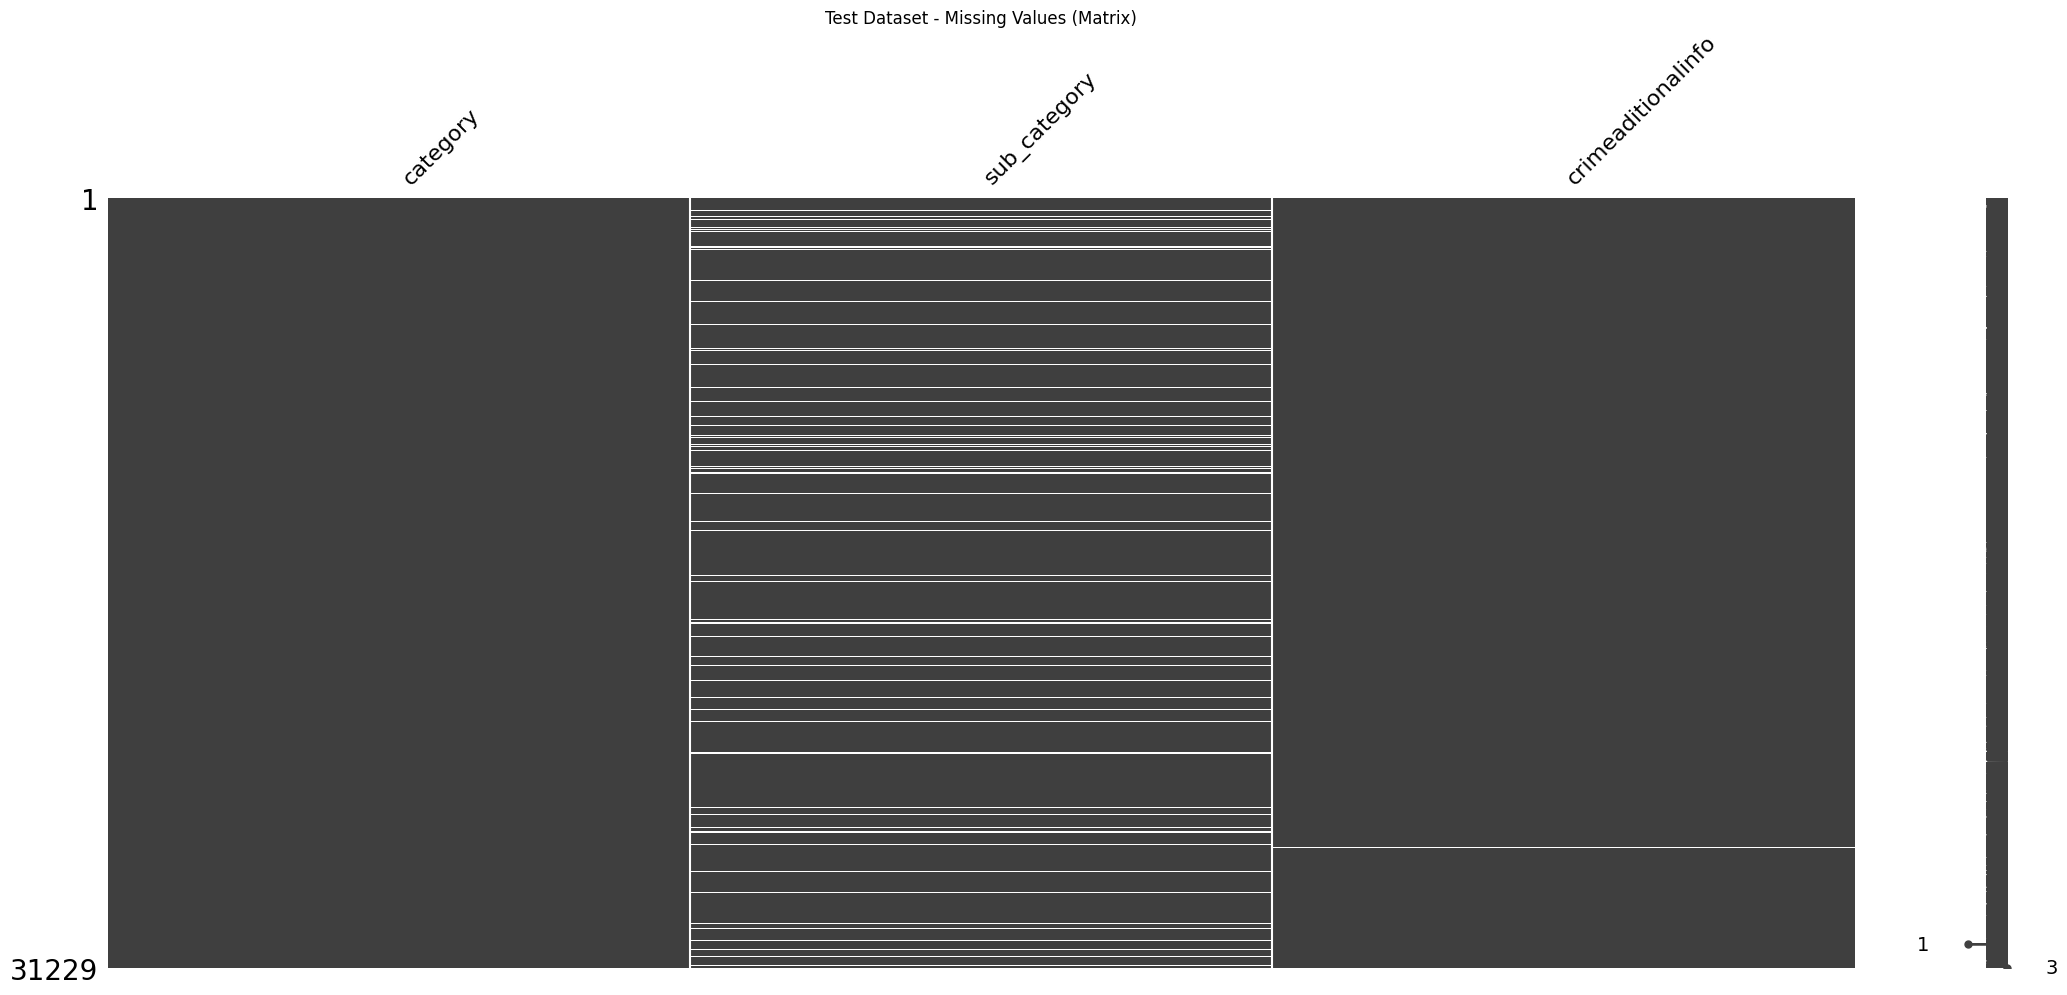

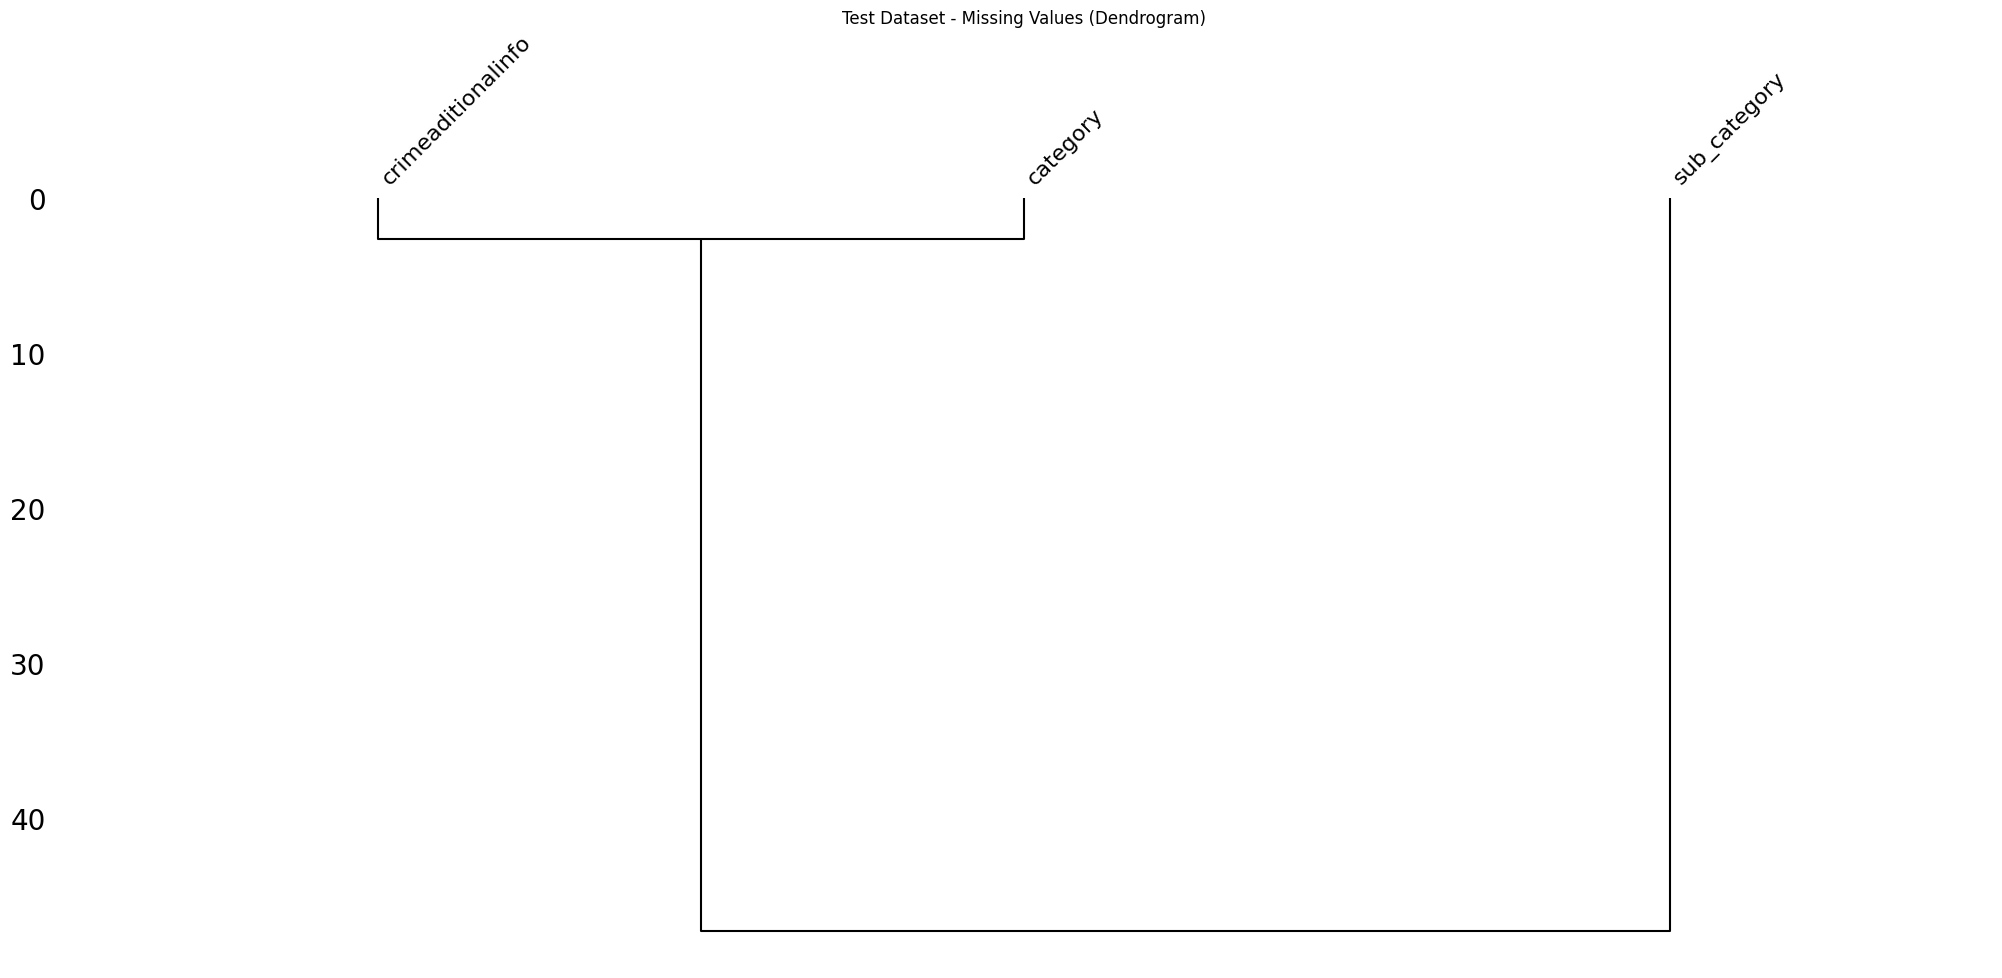

In [42]:
import missingno as msno
# Visualize missing data in the train dataset
print("Visualizing missing data in the train dataset...")
msno.bar(train_data)
plt.title("Train Dataset - Missing Values (Bar Chart)")
plt.show()

msno.matrix(train_data)
plt.title("Train Dataset - Missing Values (Matrix)")
plt.show()

msno.dendrogram(train_data)
plt.title("Train Dataset - Missing Values (Dendrogram)")
plt.show()

# Visualize missing data in the test dataset
print("Visualizing missing data in the test dataset...")
msno.bar(test_data)
plt.title("Test Dataset - Missing Values (Bar Chart)")
plt.show()

msno.matrix(test_data)
plt.title("Test Dataset - Missing Values (Matrix)")
plt.show()

msno.dendrogram(test_data)
plt.title("Test Dataset - Missing Values (Dendrogram)")
plt.show()

# Insight on the output that we got in term of Missing value result:-
Missing Values in crimeaditionalinfo

The column crimeaditionalinfo is the core textual input for classification. Rows missing this data cannot contribute to the model training.
Missing Values in category

No missing values are present in category for both datasets, so no action is needed for this column.
Missing Values in sub_category

sub_category is the second-level target. For the training dataset, rows with missing values in sub_category should be dropped because they cannot contribute to training the sub-category model.
For the test dataset: -- We can impute missing values in sub_category with "Unknown" or handle it separately during evaluation.

In [47]:
# For Train Data Set - Drop rows with missing `crimeaditionalinfo` and `sub_category` in the train dataset
train_data = train_data.dropna(subset=['crimeaditionalinfo', 'sub_category'])
print(f"Train dataset shape after handling missing values: {train_data.shape}")

# For Test Datasaet - Drop rows with missing `crimeaditionalinfo` in the test dataset
test_data = test_data.dropna(subset=['crimeaditionalinfo'])
print(f"Test dataset shape after handling missing values: {test_data.shape}")

# Impute missing `sub_category` in the test dataset with "Unknown"
test_data.loc[:, 'sub_category'] = test_data['sub_category'].fillna("Unknown")

Train dataset shape after handling missing values: (87074, 3)
Test dataset shape after handling missing values: (31222, 3)


In [48]:
# Verify missing values in the cleaned train dataset
print("Missing values in the cleaned train dataset:")
print(train_data[['crimeaditionalinfo', 'category', 'sub_category']].isnull().sum())

# Verify missing values in the cleaned test dataset
print("\nMissing values in the cleaned test dataset:")
print(test_data[['crimeaditionalinfo', 'category', 'sub_category']].isnull().sum())

Missing values in the cleaned train dataset:
crimeaditionalinfo    0
category              0
sub_category          0
dtype: int64

Missing values in the cleaned test dataset:
crimeaditionalinfo    0
category              0
sub_category          0
dtype: int64


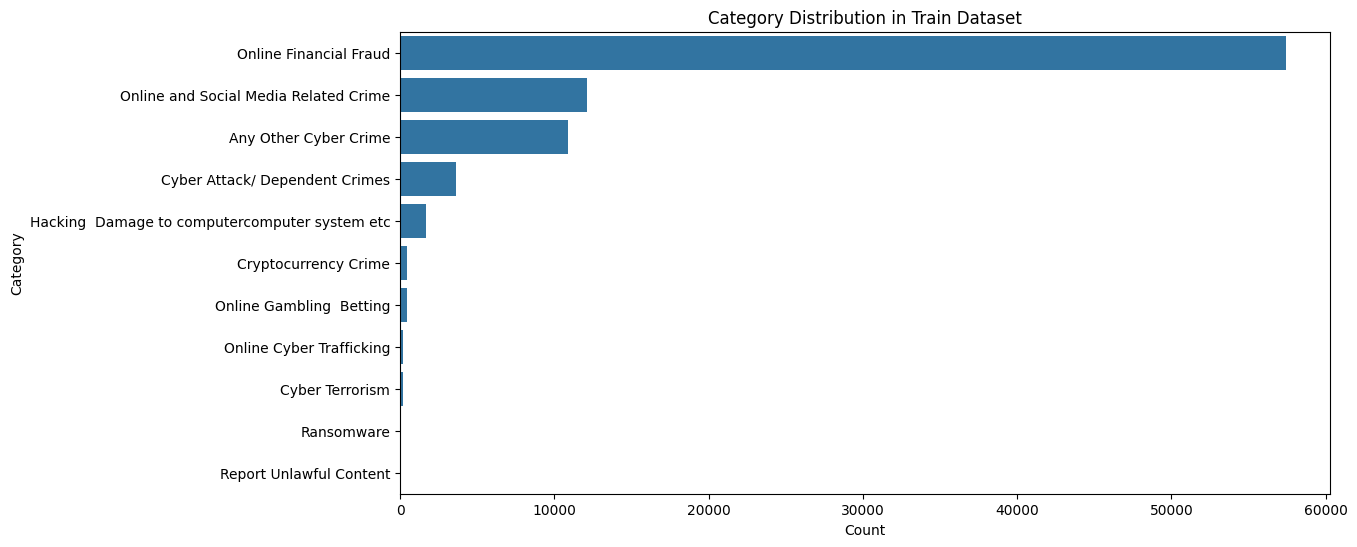

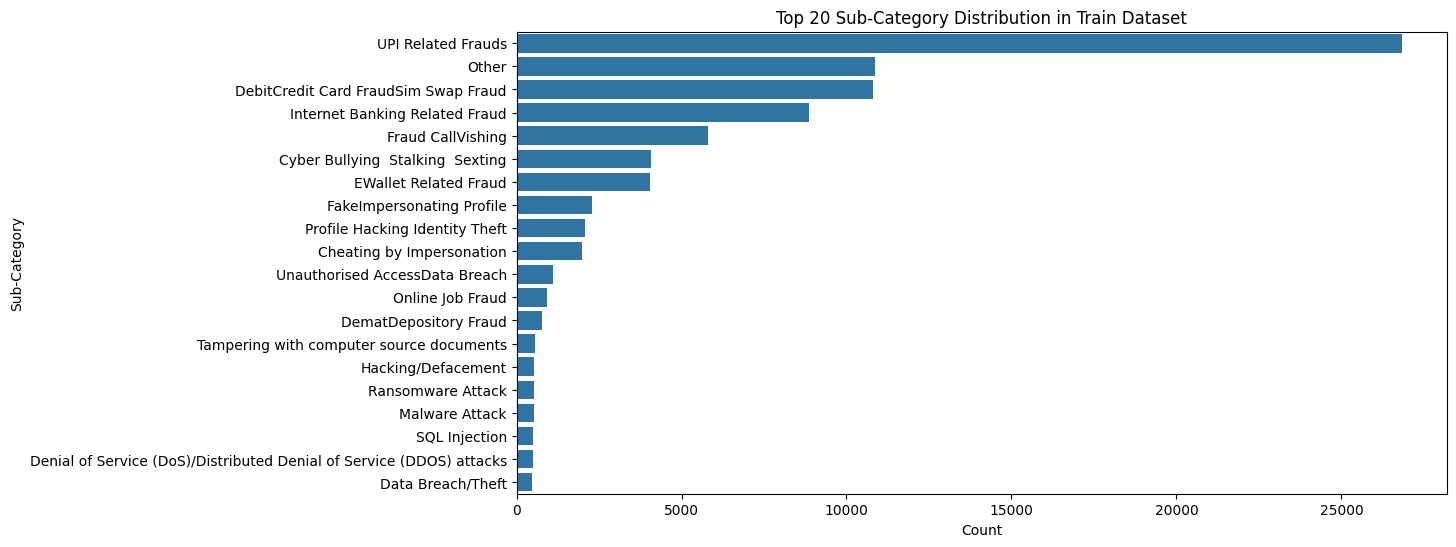

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of `category` in the train dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=train_data, y='category', order=train_data['category'].value_counts().index)
plt.title('Category Distribution in Train Dataset')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# Distribution of `sub_category` in the train dataset
plt.figure(figsize=(12, 6))
top_20_subcategories = train_data['sub_category'].value_counts().head(20)  # Show only the top 20 for readability
sns.barplot(y=top_20_subcategories.index, x=top_20_subcategories.values)
plt.title('Top 20 Sub-Category Distribution in Train Dataset')
plt.xlabel('Count')
plt.ylabel('Sub-Category')
plt.show()


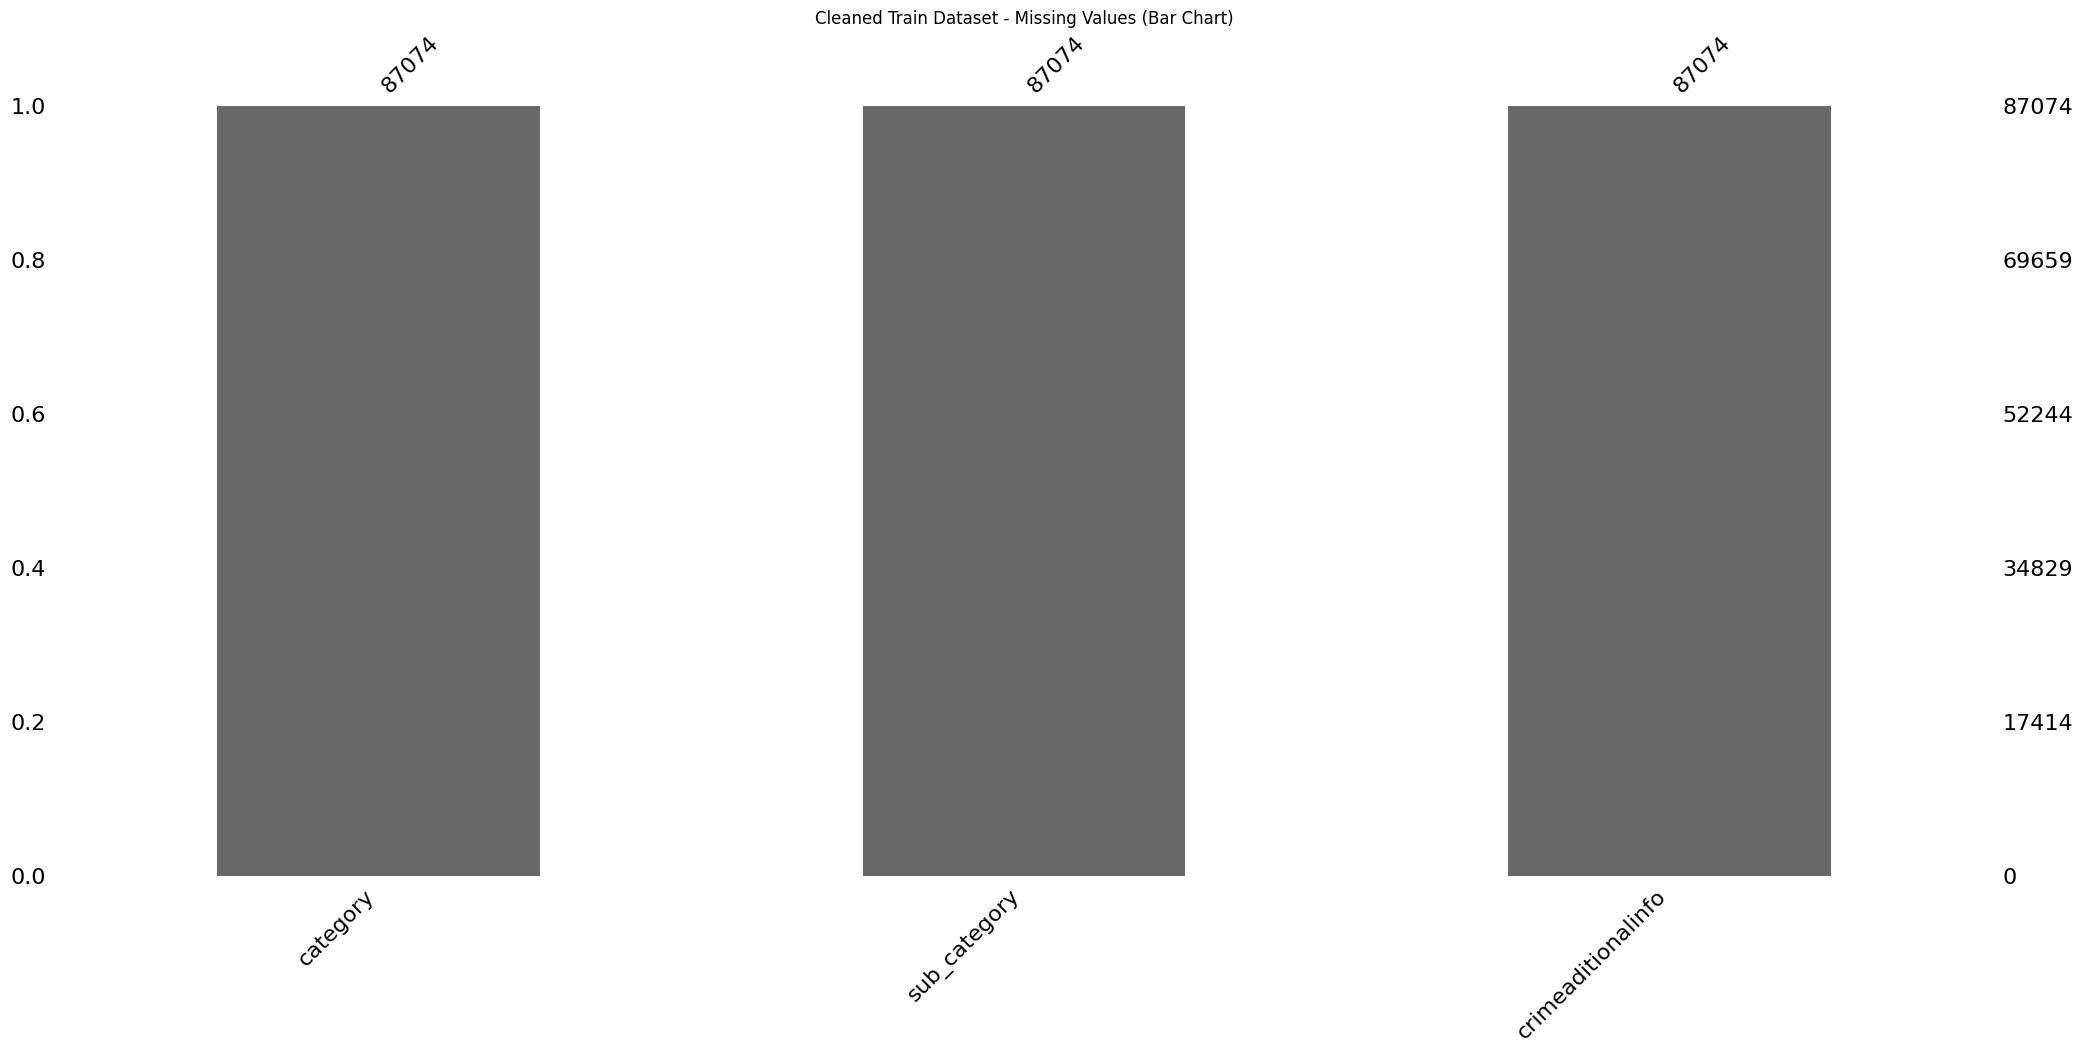

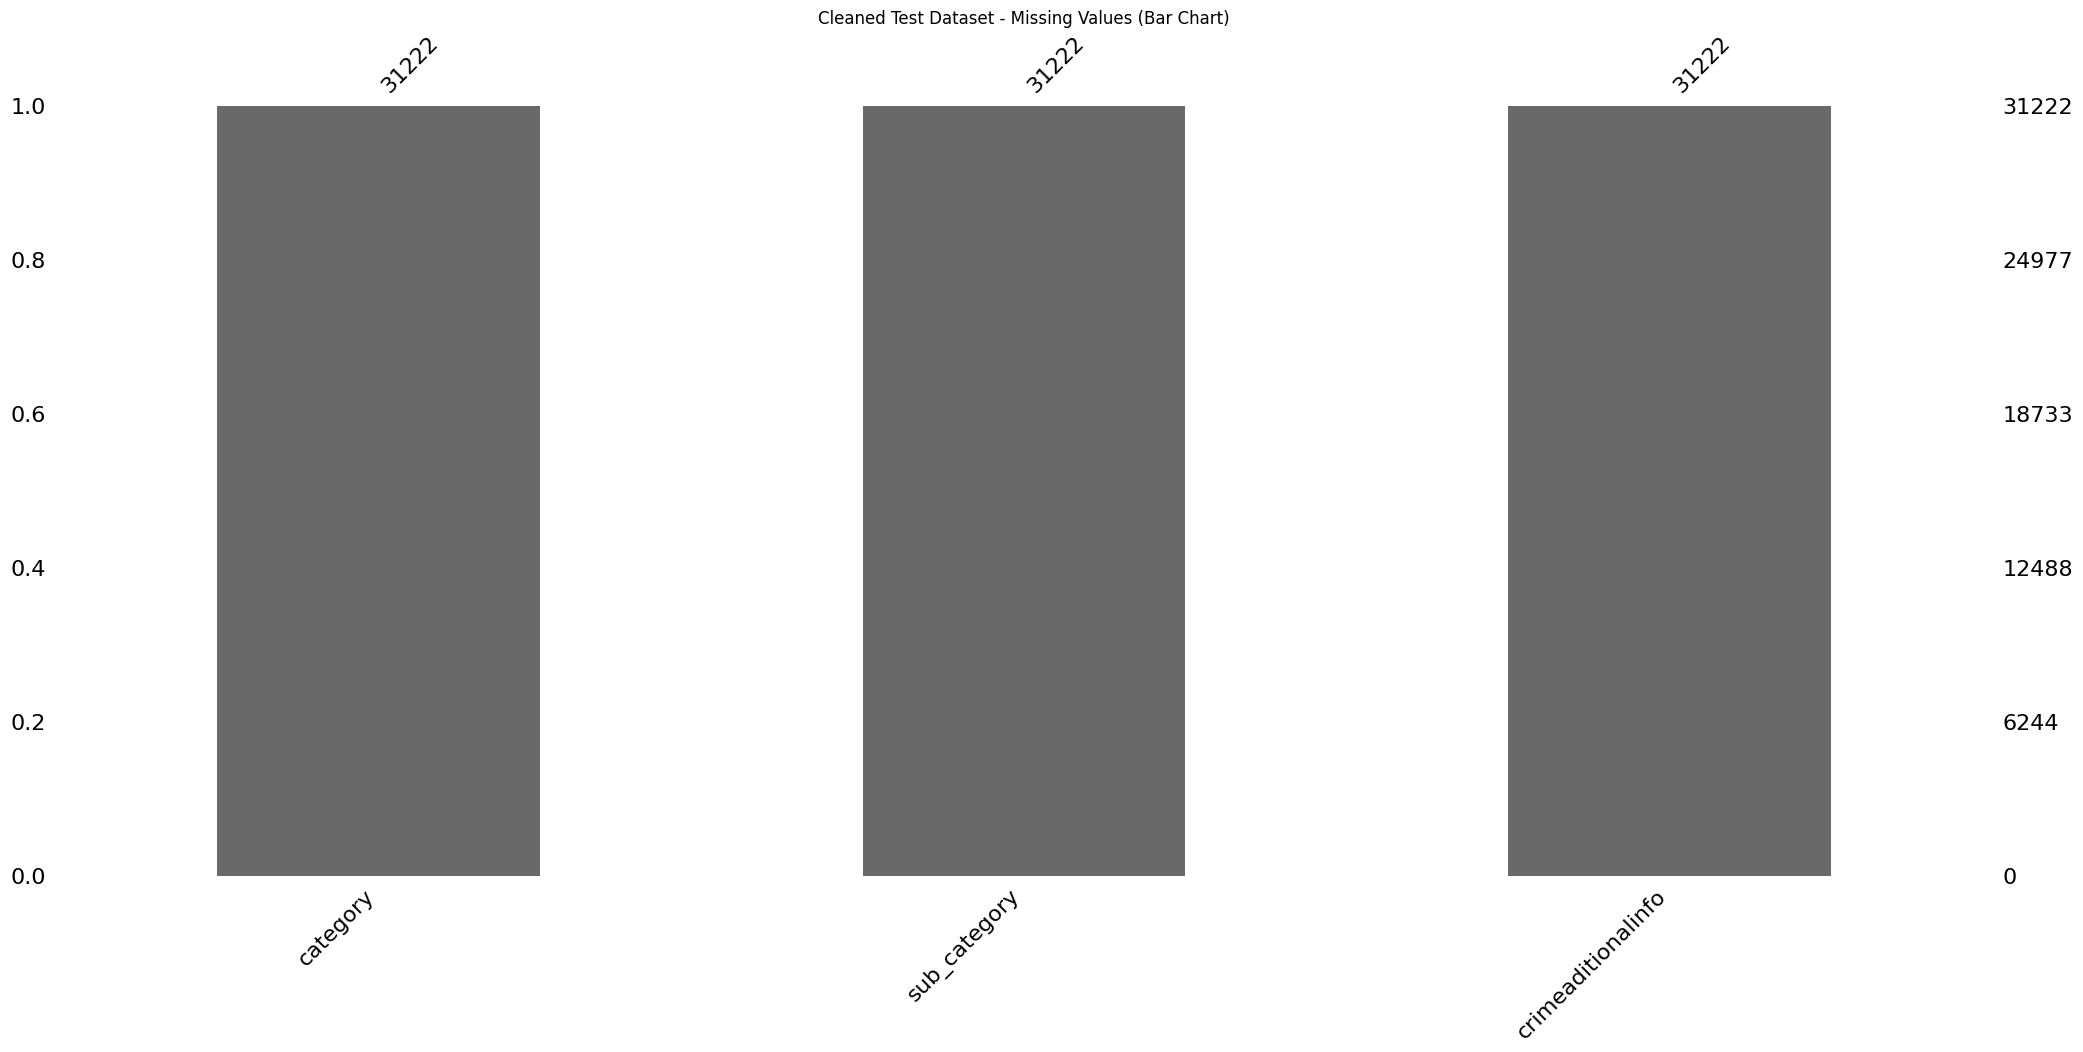

In [50]:
# Visualize missing data in the cleaned train dataset
msno.bar(train_data)
plt.title("Cleaned Train Dataset - Missing Values (Bar Chart)")
plt.show()

# Visualize missing data in the cleaned test dataset
msno.bar(test_data)
plt.title("Cleaned Test Dataset - Missing Values (Bar Chart)")
plt.show()

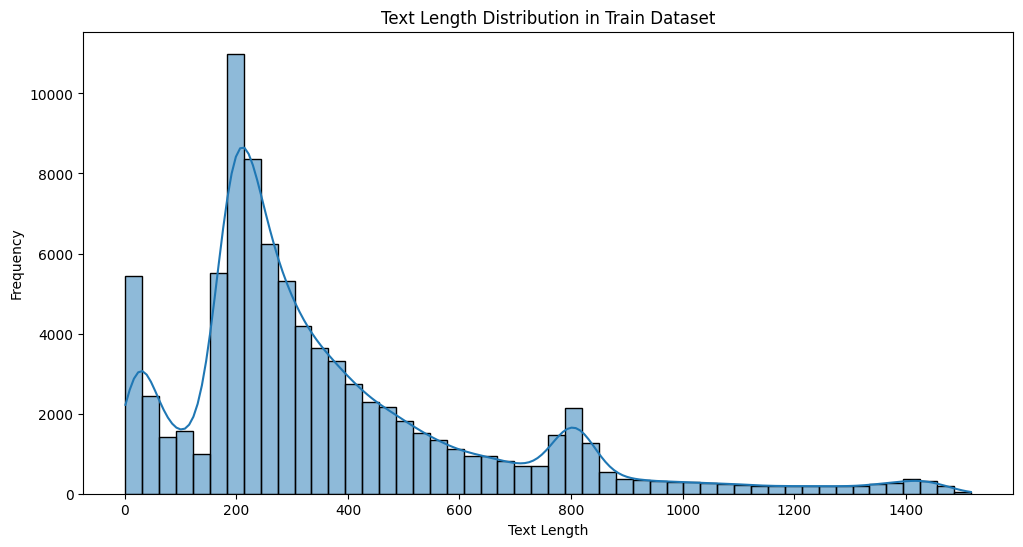

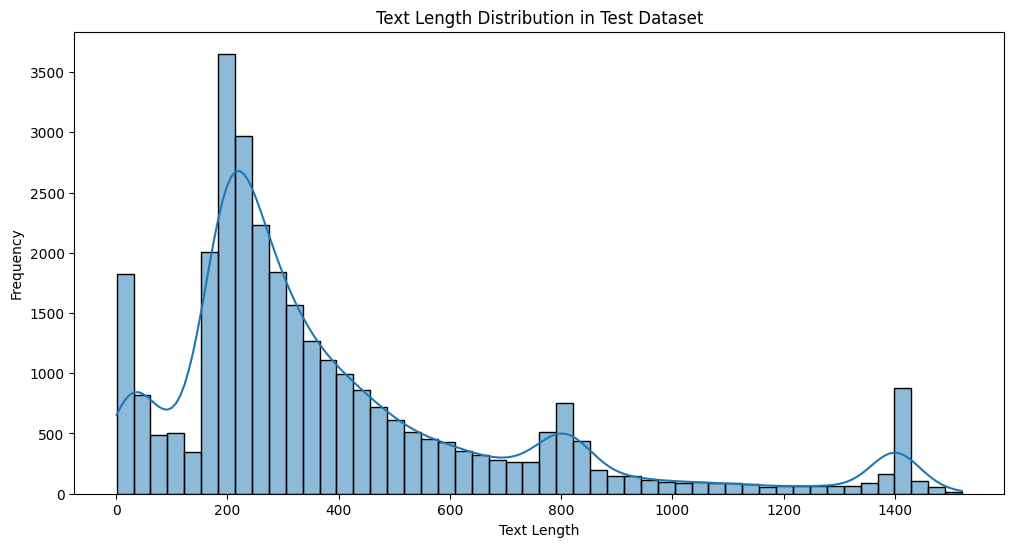

In [51]:
# Add a column for text lengths in both datasets using .loc
train_data.loc[:, 'text_length'] = train_data['crimeaditionalinfo'].str.len()
test_data.loc[:, 'text_length'] = test_data['crimeaditionalinfo'].str.len()

# Plot text length distribution in the train dataset
plt.figure(figsize=(12, 6))
sns.histplot(train_data['text_length'], bins=50, kde=True)
plt.title('Text Length Distribution in Train Dataset')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Plot text length distribution in the test dataset
plt.figure(figsize=(12, 6))
sns.histplot(test_data['text_length'], bins=50, kde=True)
plt.title('Text Length Distribution in Test Dataset')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [52]:
# Check the first few rows of the train dataset
print(train_data[['crimeaditionalinfo', 'text_length']].head())

# Check the first few rows of the test dataset
print(test_data[['crimeaditionalinfo', 'text_length']].head())

                                  crimeaditionalinfo  text_length
0  I had continue received random calls and abusi...          258
1  The above fraudster is continuously messaging ...          247
2  He is acting like a police and demanding for m...          229
3  In apna Job I have applied for job interview f...          538
4  I received a call from lady stating that she w...          194
                                  crimeaditionalinfo  text_length
0  Sir namaskar  mein Ranjit Kumar PatraPaise neh...          738
1          KOTAK MAHINDRA BANK FRAUD\r\nFRAUD AMOUNT           39
2  The issue actually started when I got this ema...          830
3  I am amit kumar from karwi chitrakoot I am tot...          134
4  I have ordered  saree and  blouse from rinki s...          258


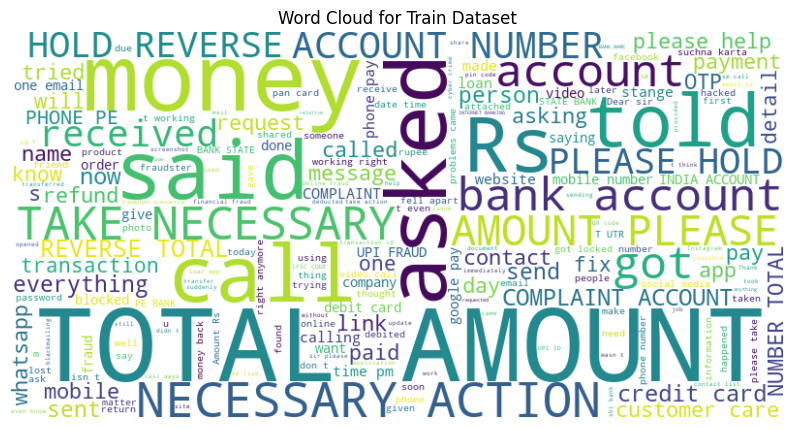

In [53]:
from wordcloud import WordCloud

# Generate a word cloud for the train dataset
text_data = ' '.join(train_data['crimeaditionalinfo'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Train Dataset')
plt.show()

In [2]:
# Preprocessing text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
train_data['cleaned_text'] = train_data['crimeaditionalinfo'].apply(preprocess_text)
test_data['cleaned_text'] = test_data['crimeaditionalinfo'].apply(preprocess_text)

# Identify unseen labels in the test data
unseen_labels = set(test_data['category']) - set(train_data['category'])
print(f"Unseen Labels in Test Data: {unseen_labels}")

# Map unseen labels to "Other"
if unseen_labels:
    train_data['category'] = train_data['category'].apply(lambda x: x if x not in unseen_labels else 'Other')
    test_data['category'] = test_data['category'].apply(lambda x: x if x not in unseen_labels else 'Other')

# Encode labels
label_encoder = LabelEncoder()
all_labels = pd.concat([train_data['category'], test_data['category']]).unique()
label_encoder.fit(all_labels)

y_train = label_encoder.transform(train_data['category'])
y_test = label_encoder.transform(test_data['category'])

# Print unique labels and label mapping
print(f"Unique Labels: {label_encoder.classes_}")
print(f"Label Mapping: {dict(enumerate(label_encoder.classes_))}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\robotics\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\robotics\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\robotics\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Unseen Labels in Test Data: {'Crime Against Women & Children'}
Unique Labels: ['Any Other Cyber Crime'
 'Child Pornography CPChild Sexual Abuse Material CSAM'
 'Cryptocurrency Crime' 'Cyber Attack/ Dependent Crimes' 'Cyber Terrorism'
 'Hacking  Damage to computercomputer system etc'
 'Online Cyber Trafficking' 'Online Financial Fraud'
 'Online Gambling  Betting' 'Online and Social Media Related Crime'
 'Other' 'Ransomware' 'RapeGang Rape RGRSexually Abusive Content'
 'Report Unlawful Content' 'Sexually Explicit Act'
 'Sexually Obscene material']
Label Mapping: {0: 'Any Other Cyber Crime', 1: 'Child Pornography CPChild Sexual Abuse Material CSAM', 2: 'Cryptocurrency Crime', 3: 'Cyber Attack/ Dependent Crimes', 4: 'Cyber Terrorism', 5: 'Hacking  Damage to computercomputer system etc', 6: 'Online Cyber Trafficking', 7: 'Online Financial Fraud', 8: 'Online Gambling  Betting', 9: 'Online and Social Media Related Crime', 10: 'Other', 11: 'Ransomware', 12: 'RapeGang Rape RGRSexually Abusive C

# Generate BERT Embeddings

In [4]:
# Load pre-trained BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_embeddings_batch(texts, tokenizer, model, device, batch_size=16):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERT Embeddings"):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
            inputs = {key: value.to(device) for key, value in inputs.items()}
            outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())
    return np.vstack(embeddings)

# Generate embeddings
train_embeddings = get_bert_embeddings_batch(train_data['cleaned_text'].tolist(), tokenizer, model, device)
test_embeddings = get_bert_embeddings_batch(test_data['cleaned_text'].tolist(), tokenizer, model, device)

# Print embedding shapes
print(f"Train Embeddings Shape: {train_embeddings.shape}")
print(f"Test Embeddings Shape: {test_embeddings.shape}")


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Train Embeddings Shape: (93665, 768)
Test Embeddings Shape: (31222, 768)


# Print Embedings 

In [5]:
print(f"Train Embeddings Mean: {train_embeddings.mean()}, Std: {train_embeddings.std()}")
print(f"Unique Labels in Training Data: {np.unique(y_train)}")

Train Embeddings Mean: -0.008517767302691936, Std: 0.30795007944107056
Unique Labels in Training Data: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15]


# Handle Class Imbalance
-- Resampling with Dynamic SMOTE and Random Oversampling

In [6]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
import numpy as np
import torch

# Count original class distribution
class_counts = Counter(y_train)
print(f"Original Class Counts: {class_counts}")

# Resampling strategy with dynamic adjustments
X_resampled, y_resampled = [], []
for cls, count in class_counts.items():
    if count < 2:  # Use RandomOverSampler for classes with <2 samples
        print(f"Class {cls} has {count} samples. Using RandomOverSampler.")
        oversampler = RandomOverSampler(sampling_strategy={cls: 10}, random_state=42)
        X_cls_resampled, y_cls_resampled = oversampler.fit_resample(train_embeddings, y_train)
    else:  # Use SMOTE for larger classes
        k_neighbors = min(5, count - 1)
        print(f"Applying SMOTE for class {cls} with k_neighbors={k_neighbors}")
        smote = SMOTE(random_state=42, sampling_strategy={cls: count * 2}, k_neighbors=k_neighbors)
        try:
            X_cls_resampled, y_cls_resampled = smote.fit_resample(train_embeddings, y_train)
        except ValueError as e:
            print(f"SMOTE failed for class {cls}: {e}. Using RandomOverSampler.")
            oversampler = RandomOverSampler(sampling_strategy={cls: count * 2}, random_state=42)
            X_cls_resampled, y_cls_resampled = oversampler.fit_resample(train_embeddings, y_train)

    X_resampled.append(X_cls_resampled)
    y_resampled.append(y_cls_resampled)

# Combine resampled data
X_train_resampled = np.vstack(X_resampled)
y_train_resampled = np.hstack(y_resampled)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long).to(device)

# Print updated class distribution
updated_class_counts = Counter(y_train_resampled)
print(f"Updated Class Counts: {updated_class_counts}")


Original Class Counts: Counter({7: 57416, 9: 12138, 0: 10877, 3: 3608, 12: 2822, 15: 1838, 5: 1710, 14: 1552, 2: 480, 8: 444, 1: 379, 6: 183, 4: 161, 11: 56, 13: 1})
Applying SMOTE for class 9 with k_neighbors=5


C:\Users\robotics\AppData\Roaming\Python\Python311\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Applying SMOTE for class 7 with k_neighbors=5
Applying SMOTE for class 8 with k_neighbors=5
Applying SMOTE for class 12 with k_neighbors=5
Applying SMOTE for class 0 with k_neighbors=5
Applying SMOTE for class 3 with k_neighbors=5
Applying SMOTE for class 2 with k_neighbors=5
Applying SMOTE for class 14 with k_neighbors=5
Applying SMOTE for class 15 with k_neighbors=5
Applying SMOTE for class 5 with k_neighbors=5
Applying SMOTE for class 4 with k_neighbors=5
Applying SMOTE for class 1 with k_neighbors=5
Applying SMOTE for class 6 with k_neighbors=5
Applying SMOTE for class 11 with k_neighbors=5
Class 13 has 1 samples. Using RandomOverSampler.
Updated Class Counts: Counter({7: 918656, 9: 194208, 0: 174032, 3: 57728, 12: 45152, 15: 29408, 5: 27360, 14: 24832, 2: 7680, 8: 7104, 1: 6064, 6: 2928, 4: 2576, 11: 896, 13: 24})


# Weighted Loss Function

In [7]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for balanced training
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Data Splitting and Data Loaders 

In [8]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Create train and validation splits
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# Convert test data to tensors
X_test_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)


# Model Defination 

In [10]:
import torch.nn as nn
import torch.optim as optim

# Define the model
class TextClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        return torch.softmax(self.fc3(x), dim=1)

# Initialize model
num_classes = len(label_encoder.classes_)
model = TextClassifier(input_dim=train_embeddings.shape[1], num_classes=num_classes).to(device)

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


# Train the Model
Train the neural network with class imbalance mitigation.

In [15]:
print(f"Total Classes (from label_encoder): {len(label_encoder.classes_)}")
print(f"Model Output Classes: {num_classes}")
print(f"Class Weights Tensor Shape: {class_weights_tensor.shape}")

Total Classes (from label_encoder): 16
Model Output Classes: 16
Class Weights Tensor Shape: torch.Size([15])


In [16]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Total classes from label encoder
total_classes = len(label_encoder.classes_)

# Compute class weights only for present classes in the training data
present_classes = np.unique(y_train_resampled)
class_weights = compute_class_weight('balanced', classes=present_classes, y=y_train_resampled)

# Create a full weight array for all classes
full_class_weights = np.zeros(total_classes, dtype=np.float32)

# Assign computed weights to the corresponding classes
for i, cls in enumerate(present_classes):
    full_class_weights[cls] = class_weights[i]

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(full_class_weights, dtype=torch.float32).to(device)
print(f"Final Class Weights Tensor Shape: {class_weights_tensor.shape}")


Final Class Weights Tensor Shape: torch.Size([16])


In [17]:
# Check model output layer
assert model.fc3.out_features == total_classes, "Mismatch between model output and total classes."


In [18]:
# Define the loss function with the corrected class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Proceed with training
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        train_correct += (outputs.argmax(dim=1) == y_batch).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            val_correct += (outputs.argmax(dim=1) == y_batch).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/20, Train Loss: 2.3744, Train Accuracy: 0.5878, Val Loss: 2.3132, Val Accuracy: 0.6289
Epoch 2/20, Train Loss: 2.3133, Train Accuracy: 0.6022, Val Loss: 2.2737, Val Accuracy: 0.6149
Epoch 3/20, Train Loss: 2.2855, Train Accuracy: 0.6153, Val Loss: 2.2450, Val Accuracy: 0.6388
Epoch 4/20, Train Loss: 2.2668, Train Accuracy: 0.6239, Val Loss: 2.2296, Val Accuracy: 0.6497
Epoch 5/20, Train Loss: 2.2531, Train Accuracy: 0.6316, Val Loss: 2.2217, Val Accuracy: 0.6491
Epoch 6/20, Train Loss: 2.2421, Train Accuracy: 0.6386, Val Loss: 2.2130, Val Accuracy: 0.6564
Epoch 7/20, Train Loss: 2.2327, Train Accuracy: 0.6470, Val Loss: 2.2013, Val Accuracy: 0.6544
Epoch 8/20, Train Loss: 2.2263, Train Accuracy: 0.6497, Val Loss: 2.1957, Val Accuracy: 0.6639
Epoch 9/20, Train Loss: 2.2189, Train Accuracy: 0.6550, Val Loss: 2.1884, Val Accuracy: 0.6786
Epoch 10/20, Train Loss: 2.2131, Train Accuracy: 0.6597, Val Loss: 2.1860, Val Accuracy: 0.6845
Epoch 11/20, Train Loss: 2.2093, Train Accuracy: 

# Evaluate on Test Data

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

# Evaluate on test data
model.eval()
test_correct = 0
test_preds = []
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_preds = test_outputs.argmax(dim=1).cpu().numpy()
    test_correct = (test_preds == y_test).sum()

# Calculate overall test accuracy
test_accuracy = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.6327


In [21]:
# Classes present in the test set
present_classes_test = np.unique(y_test)

# All classes from the label encoder
all_classes = np.arange(len(label_encoder.classes_))

# Identify missing classes
missing_classes_test = set(all_classes) - set(present_classes_test)
print(f"Missing Classes in y_test: {missing_classes_test}")


Missing Classes in y_test: {13}


In [22]:
from sklearn.metrics import classification_report

# Generate classification report with all classes included
report = classification_report(
    y_test,
    test_preds,
    target_names=label_encoder.classes_,
    labels=np.arange(len(label_encoder.classes_)),  # Include all 16 classes
    zero_division=1  # Avoid division by zero for missing classes
)

print("Classification Report:")
print(report)


Classification Report:
                                                      precision    recall  f1-score   support

                               Any Other Cyber Crime       0.30      0.50      0.38      3670
Child Pornography CPChild Sexual Abuse Material CSAM       0.30      0.29      0.29       123
                                Cryptocurrency Crime       0.21      0.78      0.33       166
                      Cyber Attack/ Dependent Crimes       1.00      1.00      1.00      1261
                                     Cyber Terrorism       1.00      0.00      0.00        52
      Hacking  Damage to computercomputer system etc       0.17      0.55      0.26       592
                            Online Cyber Trafficking       1.00      0.00      0.00        61
                              Online Financial Fraud       0.94      0.69      0.80     18890
                            Online Gambling  Betting       0.05      0.25      0.09       134
               Online and Social Med

## Foolowing Observations are made and further we can improve the same :
Overall Accuracy:

The model achieved an overall accuracy of 63%, which indicates a decent performance for the dataset size and complexity.

## Class-Level Performance:

High Precision & Recall Classes:

Cyber Attack/ Dependent Crimes: Perfect scores indicate the model handles this class very well.
RapeGang Rape RGRSexually Abusive Content: High precision and recall suggest good generalization for this class.

Online Financial Fraud: High scores but lower recall compared to precision indicate that the model is slightly biased towards predicting this class.

## Low Recall for Minority Classes:
Cyber Terrorism, Ransomware, and Online Cyber Trafficking have perfect precision but nearly zero recall, meaning these classes are predicted very rarely.
Other and similar very small classes show zero recall, likely due to insufficient training examples.

## Imbalance Issues:

The model is still biased toward majority classes like Online Financial Fraud (largest class), which skews the weighted average scores.

# Confusion Matrix 
The confusion matrix provides a detailed breakdown of model's predictions. Each cell in the confusion matrix indicates how many samples of a particular true class (rows) were predicted as a particular predicted class (columns).

<Figure size 1000x800 with 0 Axes>

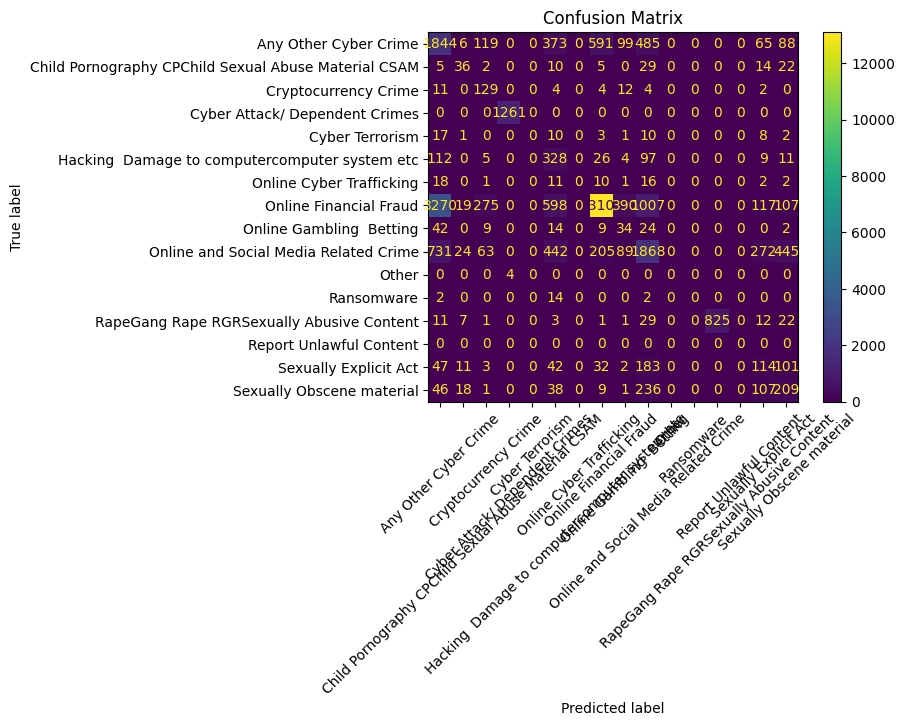

In [23]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, test_preds, labels=np.arange(total_classes))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Analyze Confusion Matrix 

In [29]:
import pandas as pd

# Define class names from the label encoder
class_names = label_encoder.classes_

# Prepare data for the table
results = []

for i, class_name in enumerate(class_names):
    tp = conf_matrix[i, i]  # True Positives
    fn = conf_matrix[i, :].sum() - tp  # False Negatives
    fp = conf_matrix[:, i].sum() - tp  # False Positives
    tn = conf_matrix.sum() - (tp + fn + fp)  # True Negatives

    results.append({
        "Class": class_name,
        "True Positives (TP)": tp,
        "False Negatives (FN)": fn,
        "False Positives (FP)": fp,
        "True Negatives (TN)": tn
    })

# Convert to DataFrame
conf_matrix_df = pd.DataFrame(results)

# Display as a table
print("Confusion Matrix Analysis Table:")
print(conf_matrix_df.to_string(index=False))


Confusion Matrix Analysis Table:
                                               Class  True Positives (TP)  False Negatives (FN)  False Positives (FP)  True Negatives (TN)
                               Any Other Cyber Crime                 1844                  1826                  4312                23240
Child Pornography CPChild Sexual Abuse Material CSAM                   36                    87                    86                31013
                                Cryptocurrency Crime                  129                    37                   479                30577
                      Cyber Attack/ Dependent Crimes                 1261                     0                     4                29957
                                     Cyber Terrorism                    0                    52                     0                31170
      Hacking  Damage to computercomputer system etc                  328                   264                  1559                

# General Insights from Confusion Matrix :

High Accuracy Classes: Cyber Attack/ Dependent Crimes, RapeGang Rape RGRSexually Abusive Content exhibit strong performance due to sufficient training data and distinguishable features.

Confused Classes: Any Other Cyber Crime, Online Financial Fraud, and Online and Social Media Related Crime show high confusion, requiring better feature extraction and class separation.

Underrepresented Classes: Classes like Cyber Terrorism, Online Cyber Trafficking, and Other need targeted resampling or synthetic data augmentation for better learning.


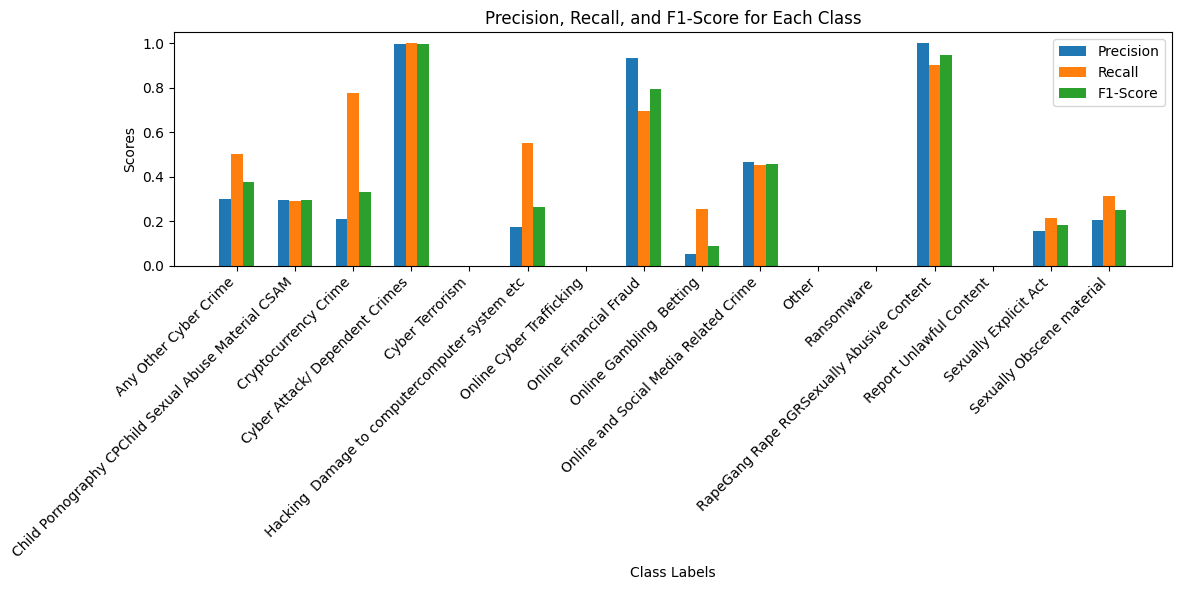

In [30]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Extract metrics with zero_division to handle undefined cases
metrics = precision_recall_fscore_support(
    y_test, test_preds, labels=np.arange(total_classes), zero_division=0
)

# Precision, recall, and F1-score for each class
precision = metrics[0]
recall = metrics[1]
f1_score = metrics[2]
support = metrics[3]

# Class labels
x_labels = label_encoder.classes_

# Plot precision, recall, and F1-score
plt.figure(figsize=(12, 6))
x = np.arange(len(x_labels))

# Plot bars
plt.bar(x - 0.2, precision, width=0.2, label="Precision", align='center')
plt.bar(x, recall, width=0.2, label="Recall", align='center')
plt.bar(x + 0.2, f1_score, width=0.2, label="F1-Score", align='center')

# Add labels and title
plt.xticks(ticks=x, labels=x_labels, rotation=45, ha="right")
plt.xlabel("Class Labels")
plt.ylabel("Scores")
plt.title("Precision, Recall, and F1-Score for Each Class")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\robotics\AppData\Local\Temp\ipykernel_1936\1982207234.py:2: RuntimeWarning: invalid value encountered in divide
  class_accuracy = conf_matrix.diagonal() / support


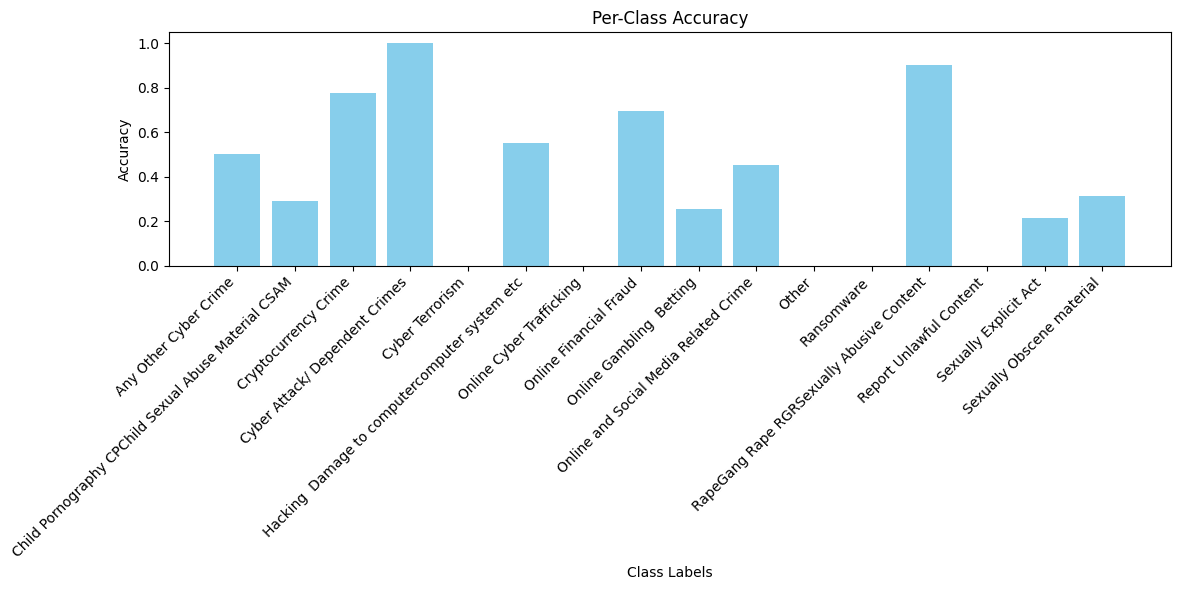

In [25]:
# Accuracy per class (correct predictions / support)
class_accuracy = conf_matrix.diagonal() / support

# Plot accuracy per class
plt.figure(figsize=(12, 6))
plt.bar(x, class_accuracy, color='skyblue', align='center')
plt.xticks(ticks=x, labels=x_labels, rotation=45, ha="right")
plt.xlabel("Class Labels")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.tight_layout()
plt.show()